<a href="https://colab.research.google.com/github/ferDMS/green-pandas-datathon/blob/main/GreenPandas_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data sourcing and preprocessing

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import hashlib
from datetime import datetime
from google.colab import files

In [6]:
# Load the 'Flights' and 'Sales' tables into DataFrame variables
flights_data = pd.read_csv('Filghts TEC_Valid.csv')

In [7]:
sales_data = pd.read_csv('Sales TEC_Valid.csv')

## Preprocessing of Flights Data


### Asignar un id único según la ruta de vuelo

In [8]:
# Convert date columns to datetime
flights_data['STD'] = pd.to_datetime(flights_data['STD'])
flights_data['STA'] = pd.to_datetime(flights_data['STA'])

# Función para crear un "hash" de la ruta
def get_route_id(row):
    # Check if either STD or STA is NaT
    if pd.isnull(row['STD']) or pd.isnull(row['STA']):
        return None

    # Extract hour and minute components from the datetime objects
    std_hour_minute = row['STD'].strftime('%H:%M')
    sta_hour_minute = row['STA'].strftime('%H:%M')

    # Concatenate the departure station, arrival station, and hour-minute components
    return f"{row['DepartureStation']}_{row['ArrivalStation']}_{std_hour_minute}_{sta_hour_minute}"

# Aplicar la función hash para crear la columna 'Route_Hash'
flights_data['Route_Hash'] = flights_data.apply(get_route_id, axis=1)

# Apply the factorize method to create the 'Route_ID' column
flights_data['Route_ID'] = flights_data['Route_Hash'].factorize()[0]

In [9]:
# Verificar el resultado mostrando entradas únicas por 'Route_ID'
unique_routes = flights_data[['Route_Hash', 'Route_ID']].drop_duplicates()
unique_routes

,Route_Hash,Route_ID
0,AL_AT_16:20_18:35,0
1,BN_AW_20:00_21:35,1
2,AT_BD_15:10_16:50,2
3,AK_AD_18:55_20:30,3
4,AO_BD_13:35_14:30,4
...,...,...
245456,AF_AW_12:05_14:45,9878
245499,AW_BA_21:40_23:10,9879
245502,BA_AY_13:25_14:05,9880
245549,AW_BC_18:00_19:30,9881


### Más procesamiento

- imputar datos de passengers que no se encuentren según el promedio de passengers para esa ruta,
- limitar datos a 2023,
- quitar datos poco relevantes

In [10]:
# Filter data for the year 2023
flights_data = flights_data[(flights_data['STD'].dt.year == 2023) & (flights_data['STD'].dt.month == 1)]

# Replacing the number of passengers with the capacity maximum of the airplane if it exceeds the capacity
flights_data['Passengers'] = flights_data[['Passengers', 'Capacity']].min(axis=1)

# Fill missing values in 'Passengers' column with median for each route
flights_data['Passengers'] = flights_data.groupby(['Route_ID'])['Passengers'].transform(lambda x: x.fillna(x.median()))

# Fill missing values in 'Bookings' column with mean for each route
flights_data['Bookings'] = flights_data.groupby(['Route_ID'])['Bookings'].transform(lambda x: x.fillna(x.mean()))

# Calculate the flight duration between STD and STA, in minutes
flights_data['Duration'] = (flights_data['STA'] - flights_data['STD']).dt.total_seconds() / 60  # in minutes

# Drop irrelevant columns and datetime columns because we already created specific unique routes and duration
flights_data.drop(columns=['Aeronave', 'Route_Hash'], inplace=True)

# Display the modified DataFrame
flights_data.head()

<ipython-input-10-861a39a8b28f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_data['Passengers'] = flights_data[['Passengers', 'Capacity']].min(axis=1)


,Flight_ID,DepartureStation,ArrivalStation,Destination_Type,Origin_Type,STD,STA,Capacity,Passengers,Bookings,Route_ID,Duration
35,0007cd6471e979f952d9cbaa96056d0e,BM,AO,Ciudad Principal,Ciudad Fronteriza,2023-01-19 23:55:00,2023-01-20 04:50:00,186,185.0,103.0,35,295.0
58,000d59b788ff90e47fcbf45156169f5b,BH,AJ,MX Amigos y Familia,Playa,2023-01-04 20:50:00,2023-01-04 21:40:00,186,170.0,101.0,58,50.0
72,00117494ce95bd1fa521f6ae3e9ead6e,BH,AT,Ciudad Principal,Playa,2023-01-29 21:50:00,2023-01-30 01:05:00,240,212.0,120.0,72,195.0
124,00204c7cf64959d95cd89f6a671a222d,AB,AT,Ciudad Principal,Playa,2023-01-12 18:50:00,2023-01-12 20:05:00,220,180.0,112.0,123,75.0
131,00220260a070a2f42fe3e2a01114b52d,AO,AT,Ciudad Principal,Ciudad Principal,2023-01-29 16:10:00,2023-01-29 17:35:00,180,176.0,132.0,128,85.0


## Preprocessing of Sales Data

In [11]:
# Usar únicamente productos relevantes (que van en vuelo)
categories_to_keep = ['Botanas', 'Licores', 'Refrescos', 'Galletas', 'Sopas',
                      'Perecederos', 'Bebidas Calientes', 'Lacteos', 'Alimentos Charter']

# Filtrar el DataFrame para mantener solo las categorías deseadas
sales_data = sales_data[sales_data['ProductType'].isin(categories_to_keep)]

## Después de filtrado, unir tablas para obtener productos a analizar

In [12]:
# Join the tables on the common column 'Flight_ID'
merged_data = pd.merge(flights_data, sales_data, on='Flight_ID', how='left')
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146830 entries, 0 to 146829
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Flight_ID         146830 non-null  object        
 1   DepartureStation  146830 non-null  object        
 2   ArrivalStation    146830 non-null  object        
 3   Destination_Type  146830 non-null  object        
 4   Origin_Type       146830 non-null  object        
 5   STD               146830 non-null  datetime64[ns]
 6   STA               146830 non-null  datetime64[ns]
 7   Capacity          146830 non-null  int64         
 8   Passengers        146830 non-null  float64       
 9   Bookings          146830 non-null  float64       
 10  Route_ID          146830 non-null  int64         
 11  Duration          146830 non-null  float64       
 12  ProductType       145999 non-null  object        
 13  ProductName       145999 non-null  object        
 14  Quan

# Data visualization

## Total sales from random flight routes

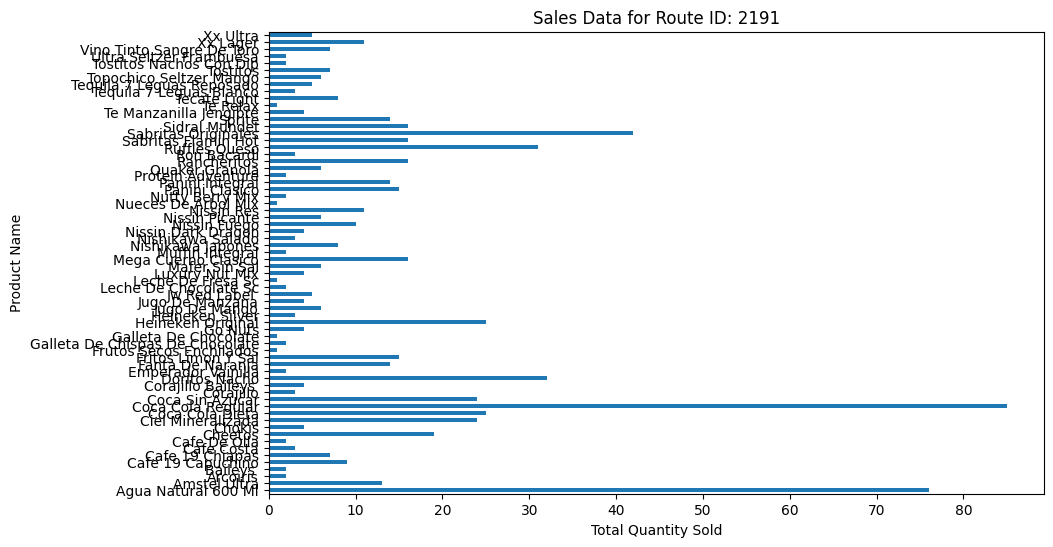

In [13]:
# Select a random route ID
random_route_id = np.random.choice(merged_data['Route_ID'].unique())

# Filter the DataFrame for the selected Route ID
random_route_data = merged_data[merged_data['Route_ID'] == random_route_id]

# Create a simple horizontal visualization of the grouped data
plt.figure(figsize=(10, 6))
random_route_data.groupby('ProductName')['Quantity'].sum().plot(kind='barh')
plt.title(f'Sales Data for Route ID: {random_route_id}')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product Name')
plt.show()

## In how many flights Y are X quantity of products sold?

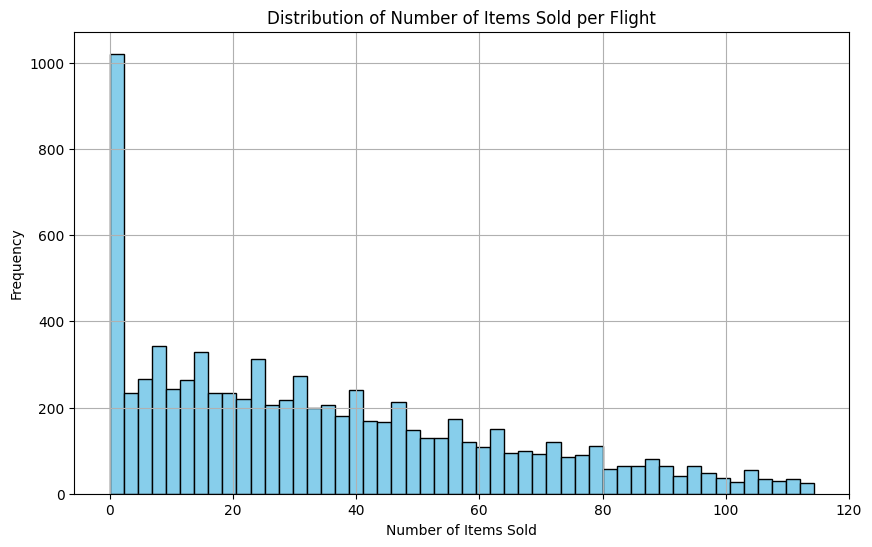

In [14]:
# Group the data by Flight ID and calculate the total number of items sold per flight
items_sold_per_flight = merged_data.groupby('Flight_ID')['Quantity'].sum()

# Define the range for the x-axis (remove outliers)
x_range = (0, items_sold_per_flight.quantile(0.95))

# Plot the distribution of number of items sold per flight
plt.figure(figsize=(10, 6))
plt.hist(items_sold_per_flight, bins=50, range=x_range, color='skyblue', edgecolor='black')
plt.title('Distribution of Number of Items Sold per Flight')
plt.xlabel('Number of Items Sold')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## How much of each type of product is sold (sales frequency)

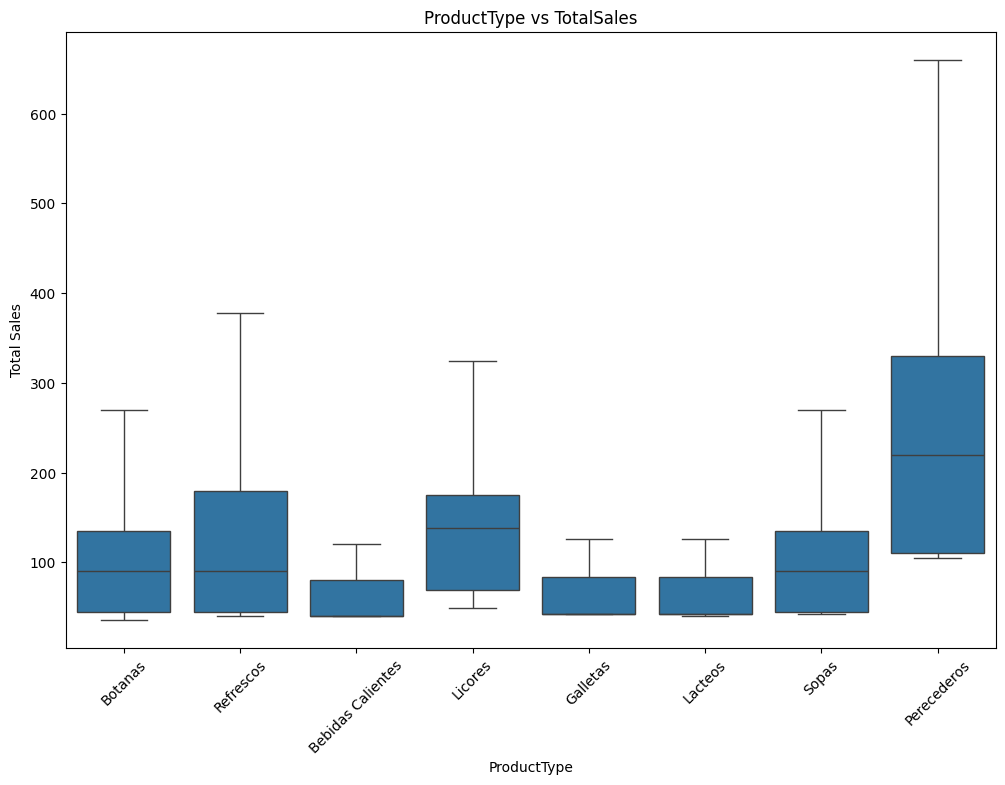

In [15]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='ProductType', y='TotalSales', data=merged_data, showfliers=False)  # Showing outliers
plt.title('ProductType vs TotalSales')
plt.xlabel('ProductType')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

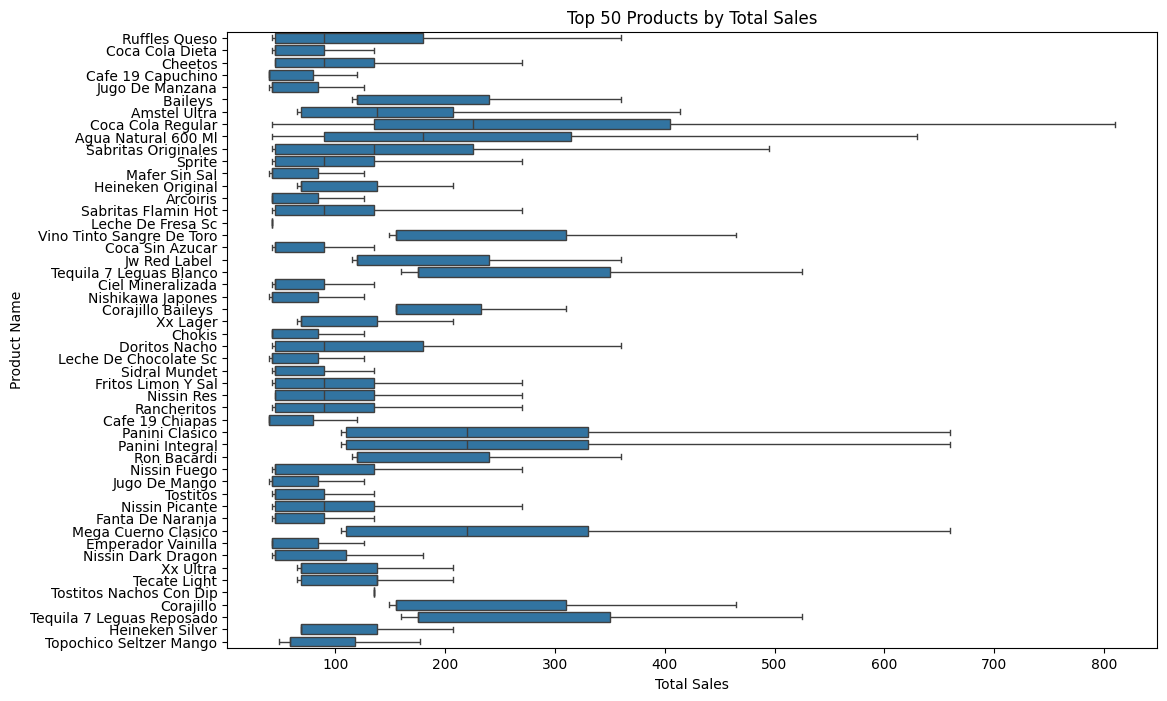

In [16]:
# Calculate total sales for each product
product_sales = merged_data.groupby('ProductName')['TotalSales'].sum().reset_index()

# Select the top 10 products
top_10_products = product_sales.nlargest(50, 'TotalSales')['ProductName']

# Filter the original data for the top 10 products
merged_data_top_10 = merged_data[merged_data['ProductName'].isin(top_10_products)]

# Relationship between ProductName and TotalSales for top 10 products (horizontal)
plt.figure(figsize=(12, 8))
sns.boxplot(x='TotalSales', y='ProductName', data=merged_data_top_10, showfliers=False)  # No outliers
plt.title('Top 50 Products by Total Sales')
plt.xlabel('Total Sales')
plt.ylabel('Product Name')
plt.show()


# Model training

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, log_loss
from sklearn.preprocessing import OneHotEncoder

In [18]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146830 entries, 0 to 146829
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Flight_ID         146830 non-null  object        
 1   DepartureStation  146830 non-null  object        
 2   ArrivalStation    146830 non-null  object        
 3   Destination_Type  146830 non-null  object        
 4   Origin_Type       146830 non-null  object        
 5   STD               146830 non-null  datetime64[ns]
 6   STA               146830 non-null  datetime64[ns]
 7   Capacity          146830 non-null  int64         
 8   Passengers        146830 non-null  float64       
 9   Bookings          146830 non-null  float64       
 10  Route_ID          146830 non-null  int64         
 11  Duration          146830 non-null  float64       
 12  ProductType       145999 non-null  object        
 13  ProductName       145999 non-null  object        
 14  Quan

In [19]:
# Columns to drop
cols_to_drop = ['ProductType', 'Flight_ID', 'STD', 'STA', 'DepartureStation', 'ArrivalStation', 'ProductName']

# Drop columns not going to be used
merged_data_encoded = merged_data.drop(columns=cols_to_drop)

# One-hot encode categorical variables
cat_cols = ['Origin_Type', 'Destination_Type', 'Route_ID']
# cat_cols = ['Origin_Type', 'Destination_Type', 'ProductName']
merged_data_encoded = pd.get_dummies(merged_data_encoded, columns=cat_cols)

# Display the first few rows of the encoded dataset
merged_data_encoded.head()


,Capacity,Passengers,Bookings,Duration,Quantity,TotalSales,Origin_Type_Ciudad Fronteriza,Origin_Type_Ciudad Principal,Origin_Type_Ecoturismo,Origin_Type_MX Amigos y Familia,...,Route_ID_9637,Route_ID_9640,Route_ID_9719,Route_ID_9728,Route_ID_9755,Route_ID_9762,Route_ID_9767,Route_ID_9774,Route_ID_9821,Route_ID_9867
0,186,185.0,103.0,295.0,NaN,NaN,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,186,170.0,101.0,50.0,1.0,45.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,186,170.0,101.0,50.0,1.0,45.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,186,170.0,101.0,50.0,1.0,45.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,186,170.0,101.0,50.0,1.0,40.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [20]:
# Split the data into features (X) and target variable (y)
X = merged_data_encoded.drop(columns=['Passengers'])
y = merged_data_encoded['Passengers']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:
X

,Capacity,Bookings,Duration,Quantity,TotalSales,Origin_Type_Ciudad Fronteriza,Origin_Type_Ciudad Principal,Origin_Type_Ecoturismo,Origin_Type_MX Amigos y Familia,Origin_Type_Playa,...,Route_ID_9637,Route_ID_9640,Route_ID_9719,Route_ID_9728,Route_ID_9755,Route_ID_9762,Route_ID_9767,Route_ID_9774,Route_ID_9821,Route_ID_9867
0,186,103.0,295.0,NaN,NaN,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,186,101.0,50.0,1.0,45.0,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,186,101.0,50.0,1.0,45.0,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,186,101.0,50.0,1.0,45.0,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,186,101.0,50.0,1.0,40.0,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146825,220,127.0,165.0,3.0,330.0,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
146826,220,127.0,165.0,1.0,110.0,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
146827,220,127.0,165.0,1.0,42.0,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
146828,220,127.0,165.0,4.0,440.0,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# Model selection and training
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Definir los parámetros a buscar
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Crear un objeto XGBoost Regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror')

# Realizar búsqueda de hiperparámetros con validación cruzada
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo y sus hiperparámetros
best_estimator = grid_search.best_estimator_
best_params = grid_search.best_params_

# Entrenar el mejor modelo en el conjunto de entrenamiento completo
best_estimator.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [ ]:
# Generar las predicciones en el conjunto de datos de prueba
y_pred = best_estimator.predict(dtest)

# Crear un nuevo DataFrame con las predicciones y_test y y_pred
predictions_df = pd.DataFrame({'y_test': y_test, 'Predictions': y_pred})

# Mostrar las primeras filas del DataFrame resultante
predictions_df.sample(20)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calcular el error absoluto medio
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calcular el error cuadrático medio
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calcular la raíz del error cuadrático medio
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

# Calcular el coeficiente de determinación (R2)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)
